<a href="https://colab.research.google.com/github/delte1821/ML-SERS/blob/master/ML_SERS_v2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf
from scipy import stats
import xgboost as xgb


rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def initialize_paths(file_path):
    figure_path = os.path.join(file_path, "Figures")
    if not os.path.exists(figure_path):
        os.makedirs(figure_path)
    return figure_path

In [5]:
def load_data(file_path):
    df = pd.read_excel(file_path, header=None)
    materials = df.iloc[0, :].astype(int)  # Ensure materials are integers
    concentrations = df.iloc[1, :].astype(float)
    data = df.iloc[2:, :].values
    return data, materials, concentrations

In [6]:
def filter_by_material(data, materials, concentrations, material_type):
    indices = materials == material_type
    filtered_data = data[:, indices]
    filtered_concentrations = concentrations[indices]

    return filtered_data, filtered_concentrations

In [7]:
def preprocess_data(data):
    nsamples, nx, ny = data.shape
    data_2d = data.reshape((nsamples, nx * ny))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_2d)
    data_reshaped = data_scaled.reshape(nsamples, nx, ny)
    return data_reshaped

In [8]:
def augment_data(data, labels, num_augmented_samples=20):
    augmented_data = []
    augmented_labels = []
    original_len = len(data)
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.1, sample.shape)
            augmented_sample = sample + noise

            # Additional augmentations
            scale_factor = np.random.uniform(0.9, 1.1)
            augmented_sample = augmented_sample * scale_factor

            shift_value = np.random.uniform(-0.1, 0.1, sample.shape)
            augmented_sample = augmented_sample + shift_value

            augmented_data.append(augmented_sample)
            augmented_labels.append(label)
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)
    print(f"Original data size: {original_len}, Augmented data size: {len(augmented_data)}")
    return augmented_data, augmented_labels


In [22]:
def augment_entire_dataset(data, labels, num_augmented_samples=20):
    augmented_data = []
    augmented_labels = []
    original_len = len(data)
    for sample, label in zip(data, labels):
        augmented_data.append(sample)
        augmented_labels.append(label)
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.05, sample.shape)
            augmented_sample = sample + noise

            # Additional augmentations
            scale_factor = np.random.uniform(0.95, 1.05)
            augmented_sample = augmented_sample * scale_factor

            shift_value = np.random.uniform(-0.05, 0.05, sample.shape)
            augmented_sample = augmented_sample + shift_value

            augmented_data.append(augmented_sample)
            augmented_labels.append(label)

    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)
    print(f"Original data size: {original_len}, Augmented data size: {len(augmented_data)}")
    return augmented_data, augmented_labels


In [23]:
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(16, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, kernel_regularizer=l2(0.01))  # Output layer for concentration prediction
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [24]:
def build_nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [25]:
def train_nn_regression(X_train, y_train, X_val, y_val, epochs=100, batch_size=32, use_early_stopping=True):
    model = build_nn_model((X_train.shape[1],))

    # Early stopping callback
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] if use_early_stopping else []

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    return model, mse, r2, history

In [26]:
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso, ElasticNet

def train_and_validate(data, materials, concentrations, material_types, display=True, figure_path=None, epochs=200, batch_size=128, num_augmented_samples=100, use_early_stopping=True):
    results = {}
    fig_counter = 1

    for mat_type in material_types:
        X, y = filter_by_material(data, materials, concentrations, mat_type)

        # Data augmentation
        X_augmented, y_augmented = augment_data(X.T, y, num_augmented_samples)
        X_augmented = X_augmented.T  # Transpose back to original shape

        # Check sizes before processing
        print(f"Original X shape: {X.shape}, Augmented X shape: {X_augmented.shape}, Augmented y shape: {y_augmented.shape}")

        # Ensure X and y have consistent length
        assert X_augmented.shape[1] == len(y_augmented), "Inconsistent number of samples between data and labels"

        X_train, X_val, y_train, y_val = train_test_split(X_augmented.T, y_augmented, test_size=0.2, random_state=42)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

        X_train = preprocess_data(X_train)
        X_val = preprocess_data(X_val)

        # Reshape back to 2D for regression models
        X_train_2d = X_train.reshape(X_train.shape[0], -1)
        X_val_2d = X_val.reshape(X_val.shape[0], -1)

        # Define and train multiple regression models
        models = {
            'Ridge': Ridge(alpha=1.0),
            'Lasso': Lasso(alpha=1.0),
            'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
            'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
            'NeuralNetwork': None  # Will be created separately
        }

        best_model = None
        best_r2 = -np.inf
        best_name = ""

        for name, model in models.items():
            if name == 'NeuralNetwork':
                model, mse, r2, history = train_nn_regression(X_train_2d, y_train, X_val_2d, y_val, epochs=epochs, batch_size=batch_size, use_early_stopping=use_early_stopping)
            else:
                model.fit(X_train_2d, y_train)
                y_pred = model.predict(X_val_2d)
                mse = mean_squared_error(y_val, y_pred)
                r2 = r2_score(y_val, y_pred)

            print(f"{name} Regression MSE: {mse}, R2: {r2}")

            if r2 > best_r2:
                best_r2 = r2
                best_model = model
                best_name = name

        print(f"Best model: {best_name} with R2: {best_r2}")
        results[mat_type] = (best_model, best_r2)

        # Save the best model's predictions and plots
        if display:
            y_pred = best_model.predict(X_val_2d) if best_name != 'NeuralNetwork' else best_model.predict(X_val_2d).flatten()
            plot_predictions(y_val, y_pred, mat_type, fig_counter, figure_path)
            if best_name == 'NeuralNetwork':
                plot_training_history(history, mat_type, fig_counter, figure_path)

        fig_counter += 1
    return results


In [27]:
def plot_predictions(y_true, y_pred, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_LR_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, c='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
    plt.xlabel('Actual Concentrations')
    plt.ylabel('Predicted Concentrations')
    plt.title(f'Actual vs Predicted Concentrations for {material_name}')
    r2 = r2_score(y_true, y_pred)
    plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, fontsize=18, verticalalignment='top')
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [28]:
def plot_training_history(history, material_type, fig_counter, figure_path):
    material_name = "IL6" if material_type == 1 else "TNF" if material_type == 2 else "Control"
    fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'{material_name}_TH_{fig_counter}.png')

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Epoch vs Loss for {material_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [29]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

def classify_materials(data, materials, display=True, figure_path=None, validation_size=0.2, n_components=10, num_augmented_samples=20):
    # Augment the entire dataset
    data_augmented, materials_augmented = augment_data(data.T, materials, num_augmented_samples)
    data_augmented = data_augmented.T  # Transpose back to the original shape

    print(f"Data shape after augmentation: {data_augmented.shape}")
    print(f"Labels shape after augmentation: {materials_augmented.shape}")

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_augmented.T).T  # Scale and then transpose back to original shape

    # Apply PCA for feature extraction
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled.T).T  # Apply PCA and then transpose back to original shape

    print(f"Data shape after PCA: {data_pca.shape}")
    assert data_pca.shape[1] == len(materials_augmented), f"Inconsistent number of samples between data ({data_pca.shape[1]}) and materials ({len(materials_augmented)})"

    X_train, X_val, y_train, y_val = train_test_split(data_pca.T, materials_augmented, test_size=validation_size, random_state=42)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
    class_weights_dict = dict(enumerate(class_weights))

    # Define RandomForest with hyperparameter tuning
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'criterion': ['gini', 'entropy']
    }
    clf = RandomForestClassifier(random_state=42, class_weight='balanced')
    clf_random = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

    clf_random.fit(X_train, y_train_encoded)
    best_clf = clf_random.best_estimator_

    y_pred = best_clf.predict(X_val)

    # Decode labels
    y_pred_decoded = le.inverse_transform(y_pred)

    # Convert integer labels to strings for classification_report
    target_names = [str(label) for label in le.classes_]

    # Print classification report
    print("Material Classification Report (Validation):")
    print(classification_report(y_val_encoded, y_pred, target_names=target_names))

    # Plot confusion matrix
    if display:
        plot_confusion_matrix(y_val_encoded, y_pred, target_names, figure_path)

    # Calculate and print specificity and sensitivity
    cm = confusion_matrix(y_val_encoded, y_pred)
    specificity, sensitivity = calculate_specificity_sensitivity(cm)

    # Save the sensitivity and specificity to a file
    fig_counter = 1
    results_file_path = os.path.join(figure_path, f'Sensitivity_Specificity_{fig_counter}.txt')
    while os.path.exists(results_file_path):
        fig_counter += 1
        results_file_path = os.path.join(figure_path, f'Sensitivity_Specificity_{fig_counter}.txt')
    with open(results_file_path, 'w') as f:
        for i, material in enumerate(target_names):
            f.write(f"Material: {material}\n")
            f.write(f"Specificity: {specificity[i]:.2f}\n")
            f.write(f"Sensitivity: {sensitivity[i]:.2f}\n")
            f.write("\n")

    # Also print the sensitivity and specificity to the console
    for i, material in enumerate(target_names):
        print(f"Material: {material}")
        print(f"Specificity: {specificity[i]:.2f}")
        print(f"Sensitivity: {sensitivity[i]:.2f}")
        print()


In [30]:
def calculate_specificity_sensitivity(cm):
    """
    Calculate the specificity and sensitivity for each class given a confusion matrix.

    Args:
    - cm: Confusion matrix (numpy array).

    Returns:
    - specificity: List of specificity values for each class.
    - sensitivity: List of sensitivity values for each class.
    """
    specificity = []
    sensitivity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # True Negatives
        fp = np.sum(np.delete(cm[:, i], i))  # False Positives
        fn = np.sum(np.delete(cm[i, :], i))  # False Negatives
        tp = cm[i, i]  # True Positives

        specificity.append(tn / (tn + fp))
        sensitivity.append(tp / (tp + fn))
    return specificity, sensitivity

In [31]:
def plot_confusion_matrix(y_true, y_pred, labels, figure_path, fig_counter=1):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')
    # Check if file exists and increment counter if necessary
    while os.path.exists(fig_filename):
        fig_counter += 1
        fig_filename = os.path.join(figure_path, f'CM_{fig_counter}.png')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(fig_filename)
    print(f'Confusion matrix saved{fig_filename}')
    plt.show()
    plt.close()


In [32]:
def plot_peak_intensity(data, materials, concentrations, material_type, peak_range, figure_path=None, display=True):
    """
    Plots the peak intensity for a given material type.

    Args:
    - data: 2D array of spectral data.
    - materials: 1D array of material types.
    - concentrations: 1D array of concentrations.
    - material_type: Integer representing the material type to plot.
    - peak_range: Tuple (start, end) representing the range of indices for the peak.
    - figure_path: Path to save the plot (optional).
    - display: Boolean indicating whether to display the plot.
    """
    indices = materials == material_type
    peak_data = data[peak_range[0]:peak_range[1], indices]
    avg_peak_data = np.mean(peak_data, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(concentrations[indices], avg_peak_data, 'o-', label=f'Material {material_type}')
    plt.xlabel('Concentration')
    plt.ylabel('Average Peak Intensity')
    plt.title(f'Average Peak Intensity vs Concentration for Material {material_type}')
    plt.legend()
    plt.grid(True)

    if figure_path:
        fig_filename = os.path.join(figure_path, f'Peak_Intensity_Material_{material_type}.png')
        plt.savefig(fig_filename)
        print(f'Peak intensity plot saved to {fig_filename}')

    if display:
        plt.show()
    else:
        plt.close()


In [33]:
# Paths and instantiation
file_path = "/content/drive/My Drive/Colab Notebooks/Spectra/Low"  # Update to your actual path in Google Drive
figure_path = initialize_paths(file_path)
original_file_path = os.path.join(file_path, "Combine.xlsx")
display = True
epochs = 200
batch_size = 32
num_augmented_samples=100
use_early_stopping = True

# Load and preprocess data
data, materials, concentrations = load_data(original_file_path)
material_types = [1, 2]  # Focusing on IL6 and TNF for example

Data shape after loading: (1024, 232)
Materials shape after loading: (232,)
Original data size: 124, Augmented data size: 12524
Original X shape: (1024, 124), Augmented X shape: (1024, 12524), Augmented y shape: (12524,)
Ridge Regression MSE: 7.649636386874427, R2: 0.9917472407585171
Lasso Regression MSE: 548.1035864760513, R2: 0.40868209810056444
ElasticNet Regression MSE: 561.0348808127619, R2: 0.3947312573750187
XGBoost Regression MSE: 19.0896935724306, R2: 0.9794052112964124
Epoch 1/200
314/314 [==============================] - 2s 3ms/step - loss: 645.0012 - val_loss: 488.7520
Epoch 2/200
314/314 [==============================] - 1s 3ms/step - loss: 433.7648 - val_loss: 361.4210
Epoch 3/200
314/314 [==============================] - 1s 3ms/step - loss: 302.2274 - val_loss: 630.3183
Epoch 4/200
314/314 [==============================] - 1s 3ms/step - loss: 229.4868 - val_loss: 174.5960
Epoch 5/200
314/314 [==============================] - 1s 3ms/step - loss: 153.2069 - val_loss: 

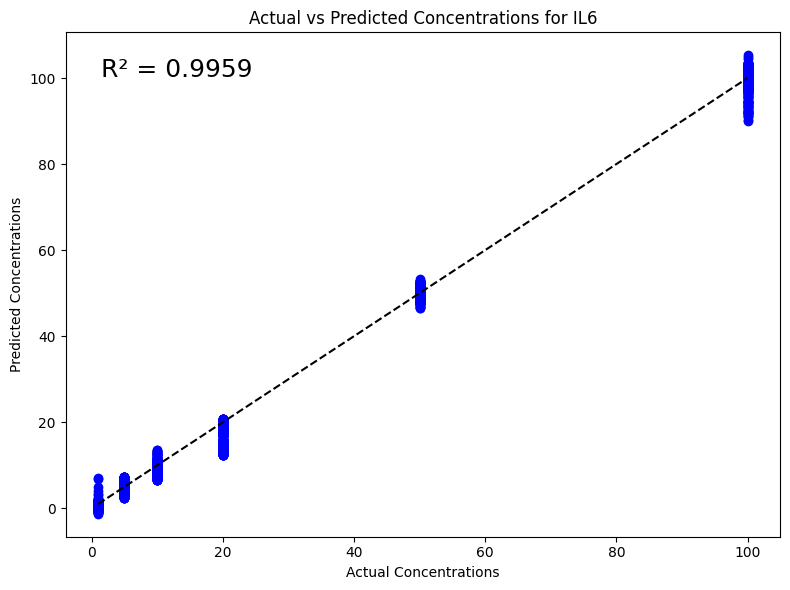

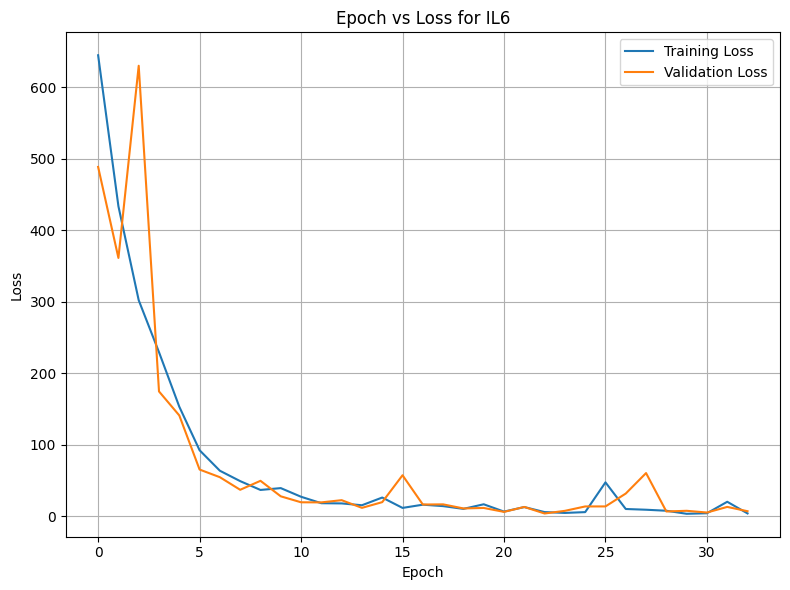

Original data size: 81, Augmented data size: 8181
Original X shape: (1024, 81), Augmented X shape: (1024, 8181), Augmented y shape: (8181,)
Ridge Regression MSE: 12.24165112710587, R2: 0.9963873009087636


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+04, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(


Lasso Regression MSE: 1013.4980197481358, R2: 0.7009011826185227


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e+06, tolerance: 2.314e+03
  model = cd_fast.enet_coordinate_descent(


ElasticNet Regression MSE: 1409.8823150602018, R2: 0.5839220947009243
XGBoost Regression MSE: 37.595726561841936, R2: 0.9889049241990243
Epoch 1/200
205/205 [==============================] - 2s 3ms/step - loss: 2904.7605 - val_loss: 1582.0431
Epoch 2/200
205/205 [==============================] - 1s 3ms/step - loss: 1085.8945 - val_loss: 1012.4622
Epoch 3/200
205/205 [==============================] - 1s 3ms/step - loss: 756.7151 - val_loss: 654.7607
Epoch 4/200
205/205 [==============================] - 1s 3ms/step - loss: 536.6191 - val_loss: 439.7826
Epoch 5/200
205/205 [==============================] - 1s 3ms/step - loss: 360.9765 - val_loss: 385.5031
Epoch 6/200
205/205 [==============================] - 1s 3ms/step - loss: 213.1678 - val_loss: 148.1334
Epoch 7/200
205/205 [==============================] - 1s 3ms/step - loss: 110.3237 - val_loss: 88.5742
Epoch 8/200
205/205 [==============================] - 1s 3ms/step - loss: 54.1605 - val_loss: 68.7686
Epoch 9/200
205/205 [=

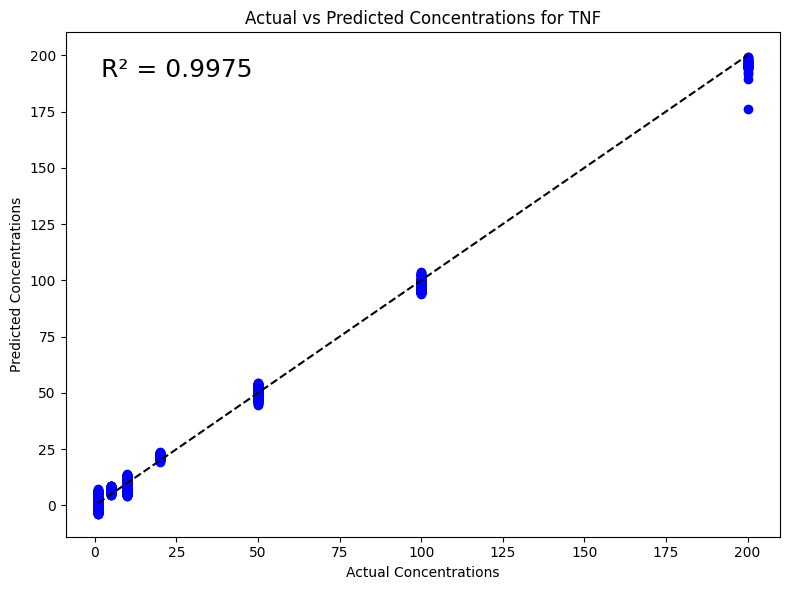

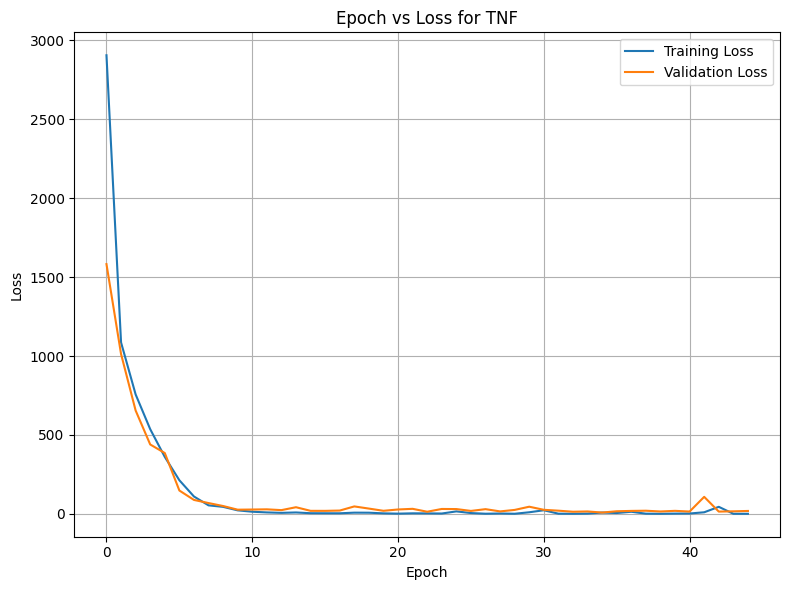

In [34]:
# Set parameters
validation_size = 0.2  # Adjust validation size if necessary
n_components = 10  # Number of principal components to use

# Check data dimensions after loading
print(f"Data shape after loading: {data.shape}")
print(f"Materials shape after loading: {materials.shape}")

# Run the train_and_validate function
results_regression = train_and_validate(data, materials, concentrations, material_types, display=display, figure_path=figure_path, epochs=epochs, batch_size=batch_size, num_augmented_samples=num_augmented_samples, use_early_stopping=use_early_stopping)


Original data size: 232, Augmented data size: 4872
Data shape after augmentation: (1024, 4872)
Labels shape after augmentation: (4872,)
Data shape after PCA: (10, 4872)
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Material Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00       514
           2       1.00      1.00      1.00       335

    accuracy                           1.00       975
   macro avg       1.00      1.00      1.00       975
weighted avg       1.00      1.00      1.00       975

Confusion matrix saved/content/drive/My Drive/Colab Notebooks/Spectra/Low/Figures/CM_13.png


<Figure size 800x600 with 0 Axes>

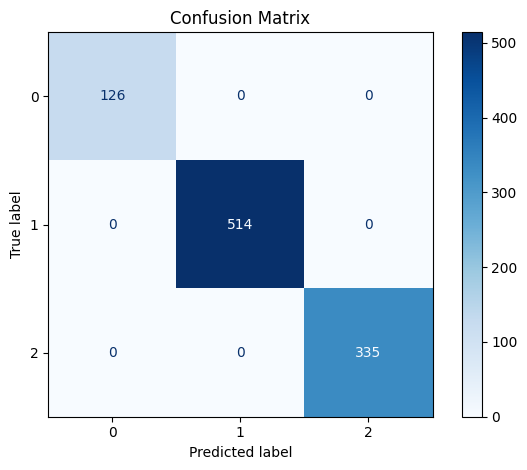

Material: 0
Specificity: 1.00
Sensitivity: 1.00

Material: 1
Specificity: 1.00
Sensitivity: 1.00

Material: 2
Specificity: 1.00
Sensitivity: 1.00



In [ ]:
# Set parameters
validation_size = 0.2  # Adjust validation size if necessary
n_components = 10  # Number of principal components to use

# Call classify_materials with appropriate data handling
classify_materials(data, materials, display=display, figure_path=figure_path, validation_size=validation_size, n_components=n_components, num_augmented_samples=20)


Peak intensity plot saved to /content/drive/My Drive/Colab Notebooks/Spectra/Low/Figures/Peak_Intensity_Material_1.png


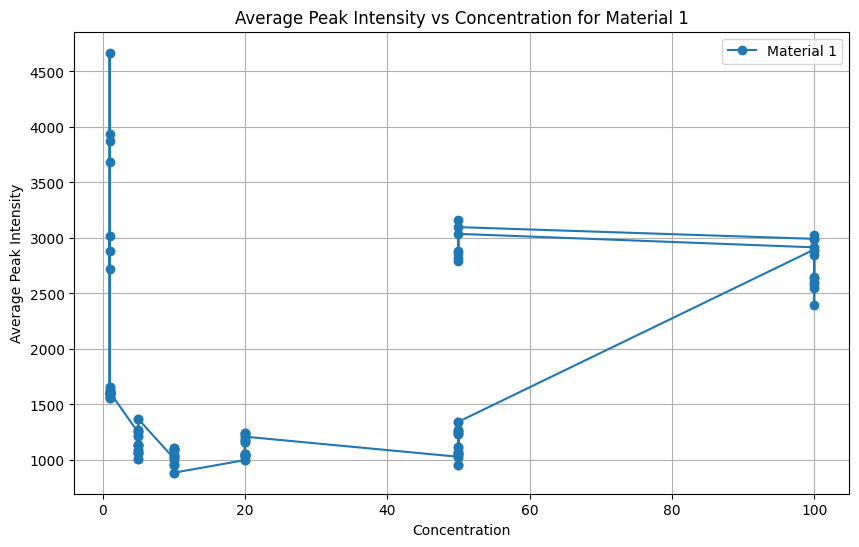

Peak intensity plot saved to /content/drive/My Drive/Colab Notebooks/Spectra/Low/Figures/Peak_Intensity_Material_2.png


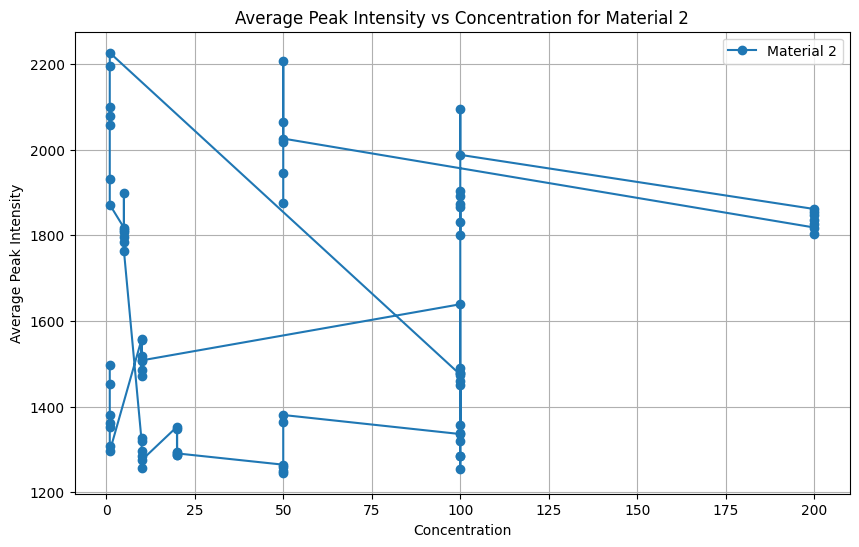

In [ ]:
# Define the peak ranges for each material type
peak_ranges = {
    1: (603, 613),  # IL6
    2: (852, 862),  # TNF
}

# Plot peak intensity for IL6 (material_type = 1)
plot_peak_intensity(data, materials, concentrations, material_type=1, peak_range=peak_ranges[1], figure_path=figure_path, display=display)

# Plot peak intensity for TNF (material_type = 2)
plot_peak_intensity(data, materials, concentrations, material_type=2, peak_range=peak_ranges[2], figure_path=figure_path, display=display)